In [47]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json


In [48]:
# read the pickle file
with open('../tracker_stub/ball_detections.pkl', 'rb') as f:
    ball_positions = pickle.load(f)
with open('../tracker_stub/court_keypoint_detections.json', 'rb') as f:
    court_keypoints = json.load(f)
court_keypoints = court_keypoints[0]

In [49]:
ball_positions

[{1: [626.1900024414062,
   796.89990234375,
   645.5587158203125,
   818.4737548828125]},
 {1: [894.3272094726562,
   617.8462524414062,
   911.5991821289062,
   634.3955078125]},
 {1: [873.7547607421875,
   638.7326049804688,
   895.7858276367188,
   659.1441040039062]},
 {1: [858.47119140625,
   645.5105590820312,
   883.2385864257812,
   671.7796020507812]},
 {},
 {},
 {1: [820.124267578125,
   686.7584838867188,
   837.4508056640625,
   703.9027709960938]},
 {1: [812.096923828125,
   692.7039794921875,
   833.360595703125,
   715.2352905273438]},
 {1: [795.52294921875, 717.2723388671875, 814.5556640625, 737.8361206054688]},
 {1: [775.7911376953125,
   739.4924926757812,
   802.959228515625,
   766.7034301757812]},
 {1: [770.2003784179688,
   759.03955078125,
   788.0176391601562,
   777.1878662109375]},
 {1: [776.0270385742188,
   716.1771240234375,
   800.29052734375,
   739.8248291015625]},
 {},
 {1: [792.4833984375,
   645.2322387695312,
   813.5797119140625,
   667.30285644531

In [50]:
ball_positions = [x.get(1,[]) for x in ball_positions]
# convert the list into pandas dataframe
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

# interpolate the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

In [51]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

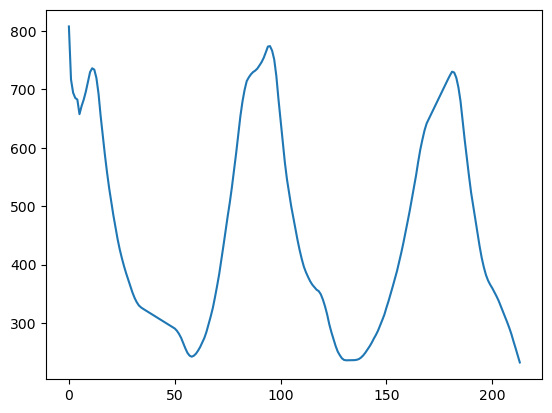

In [52]:
# plot mid_y_rolling_mean
plt.plot(df_ball_positions['mid_y_rolling_mean'])

In [53]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

In [54]:
df_ball_positions['ball_hit']=0

In [55]:
minimum_change_frames_for_hit = 25
for i in range(1,len(df_ball_positions)- int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[i+1] <0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[i+1] >0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

C:\Users\Vasu\AppData\Local\Temp\ipykernel_7824\3752280353.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_positions['ball_hit'].iloc[i] = 1


In [56]:
len(frame_nums_with_ball_hits)


5

In [57]:
for i in range(0,len(frame_nums_with_ball_hits)):
    frame_nums_with_ball_hits[i] = 30 + frame_nums_with_ball_hits[i]
frame_nums_with_ball_hits    

[41, 88, 125, 161, 211]

In [58]:
df_ball_hit_surface = df_ball_positions.loc[frame_nums_with_ball_hits]
df_ball_hit_surface['mid_x'] = (df_ball_hit_surface['x1'] + df_ball_hit_surface['x2'])/2
df_ball_hit_surface.drop(columns=['mid_y_rolling_mean','delta_y','ball_hit'])

,x1,y1,x2,y2,mid_y,mid_x
41,917.637788,298.111865,933.192193,314.671446,306.391655,925.414991
88,661.022614,731.627213,678.609756,748.275742,739.951477,669.816185
125,677.540649,237.658127,700.978516,261.738678,249.698402,689.259583
161,1050.923706,519.517883,1070.840820,539.185242,529.351562,1060.882263
211,1180.468506,224.776428,1196.754272,242.513763,233.645096,1188.611389


In [59]:
ball_positions_on_surface = list(zip(df_ball_hit_surface['mid_x'], df_ball_hit_surface['mid_y']))

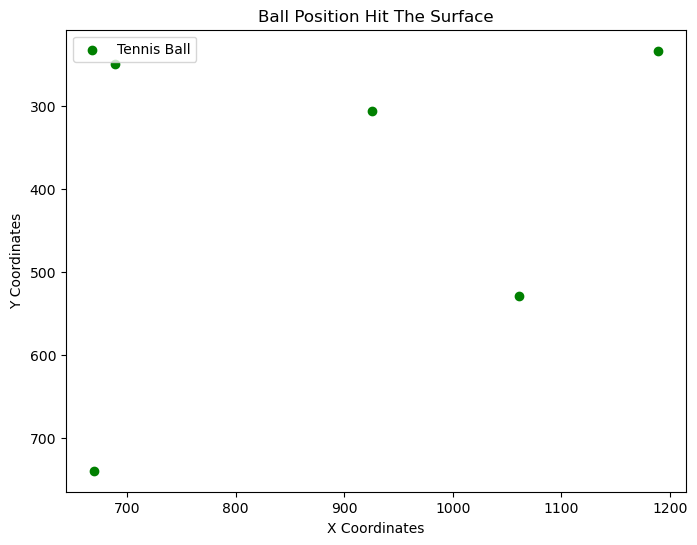

In [60]:
# Extract x and y coordinates from the list of tuples for ball
x_coords_ball = [coord[0] for coord in ball_positions_on_surface]
y_coords_ball = [coord[1] for coord in ball_positions_on_surface]



plt.figure(figsize=(8, 6))

plt.scatter(x_coords_ball, y_coords_ball, c='g', alpha=1, label='Tennis Ball')

plt.title('Ball Position Hit The Surface')
plt.xlabel('X Coordinates')
plt.ylabel('Y Coordinates')


plt.legend()

plt.gca().invert_yaxis()

plt.show()


In [61]:
class TennisCourt():
    def __init__(self, court_keypoints=None, connections=None, padding=50):
        self.court_keypoints = court_keypoints
        self.connections = connections
        self.padding = padding

    def draw_court(self, ax):
        # Plot court keypoints
        for i in range(0, len(self.court_keypoints), 2):
            ax.plot(self.court_keypoints[i], self.court_keypoints[i+1], 'ro')

        # Plot connections
        for connection in self.connections:
            start_point = connection[0] * 2
            end_point = connection[1] * 2
            ax.plot([self.court_keypoints[start_point], self.court_keypoints[end_point]], 
                    [self.court_keypoints[start_point+1], self.court_keypoints[end_point+1]], 
                    'k-', linewidth=2)
        
        ax.set_aspect('equal')

        # Set limits of x and y axes with padding
        ax.set_xlim(min(self.court_keypoints[::2]) - self.padding, max(self.court_keypoints[::2]) + self.padding)
        ax.set_ylim(min(self.court_keypoints[1::2]) - self.padding, max(self.court_keypoints[1::2]) + self.padding)

        # Draw the net
        net_start_point = (min(self.court_keypoints[::2]), int((min(self.court_keypoints[1::2]) + max(self.court_keypoints[1::2])) / 2))
        net_end_point = (max(self.court_keypoints[::2]), int((min(self.court_keypoints[1::2]) + max(self.court_keypoints[1::2])) / 2))
        ax.plot([net_start_point[0], net_end_point[0]], [.89*net_start_point[1], .89*net_start_point[1]], 'b-', linewidth=2)

        # Invert y-axis to flip the image upside down
        ax.invert_yaxis()

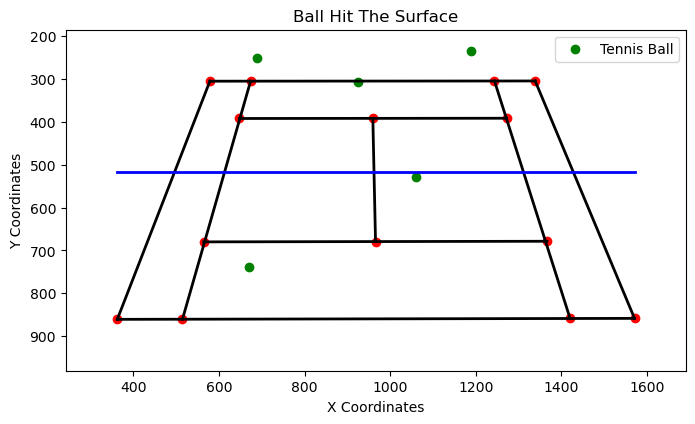

In [62]:
connections = [
    (0, 2), (4, 5), (6, 7), (1, 3),
    (0, 1), (8, 9), (10, 11), (12, 13), (2, 3)
]

# Create a TennisCourt instance with court keypoints, connections, and padding
tennis_court = TennisCourt(court_keypoints=court_keypoints, connections=connections, padding=120)

fig, ax = plt.subplots(figsize=(8, 6))


tennis_court.draw_court(ax)


x_coords_ball = [coord[0] for coord in ball_positions_on_surface]
y_coords_ball = [coord[1] for coord in ball_positions_on_surface]


ax.scatter(x_coords_ball, y_coords_ball, c='g', alpha=1, label='Tennis Ball')


ax.set_title('Ball Hit The Surface')
ax.set_xlabel('X Coordinates')
ax.set_ylabel('Y Coordinates')


ax.legend()


plt.show()

